In [1]:
import os
import sys
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

print('python version:', sys.version.split('\n')[0])
for m in [sklearn, np, mpl, sns]:
    print(m.__name__, 'version:', m.__version__)

python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
sklearn version: 0.23.2
numpy version: 1.18.5
matplotlib version: 3.3.2
seaborn version: 0.11.0


# Dataset

In [2]:
X, y = make_moons(n_samples = 2000, noise = 0.2, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)
print(X.shape, y.shape)

(2000, 2) (2000,)


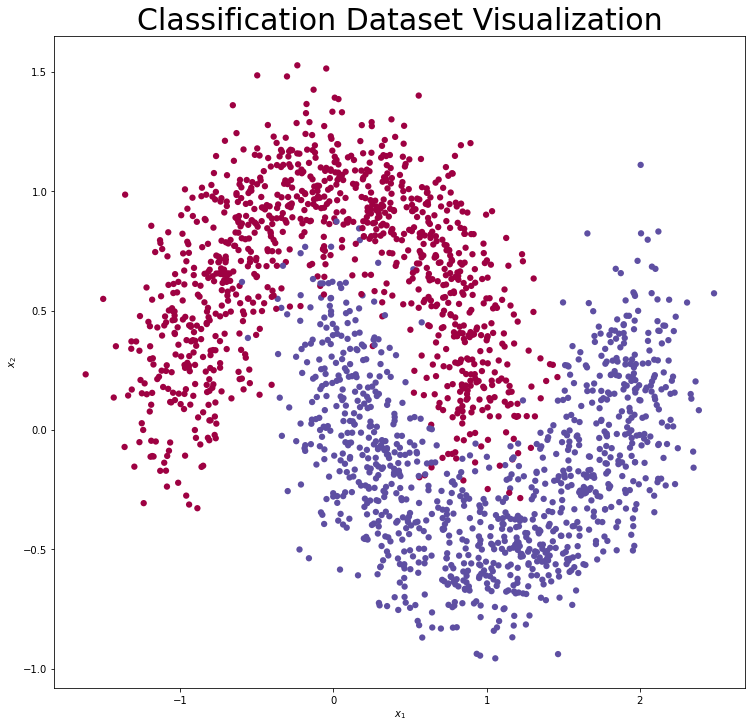

In [3]:
plt.figure(figsize=(16,12))
axes = plt.gca()
axes.set(xlabel="$x_1$", ylabel="$x_2$")
plt.title('Classification Dataset Visualization', fontsize=30)
plt.subplots_adjust(left=0.20)
plt.subplots_adjust(right=0.80)

plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='none')
plt.show()

# Network Layer

In [4]:
class Layer:
    # FC
    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None):
        """
        :param int n_input: number of input nodes
        :param int n_neurons: number of output nodes
        :param str activation: activation function
        :param weights: weight tensor
        :param bias: bias tensor
        """
        # normalize trainable variable
        self.weights = weights if weights is not None else np.random.randn(n_input, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bais if bias is not None else np.random.rand(n_neurons) * 0.1
        self.activation = activation
        self.last_activation = None # activated output
        self.error = None
        self.delta = None
        
    
    # forward propagation
    def activate(self, x):
        r = np.dot(x, self.weights) + self.bias
        self.last_activation = self._apply_activation(r) # activation
        return self.last_activation
    
    
    # activation function
    def _apply_activation(self, r):
        
        if self.activation is None:
            return r
        # ReLU 
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        # tanh
        elif self.activation == 'tanh':
            return np.tanh(r)
        # sigmoid
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        return r
    
    
    def apply_activation_derivative(self, r):

        if self.activation is None:
            return np.ones_like(r)
        # ReLU 
        elif self.activation == 'relu':
            grad = np.array(r, copy=True)
            grad[r > 0] = 1.
            grad[r <= 0] = 0.
            return grad
        # tanh 
        elif self.activation == 'tanh':
            return 1 - r ** 2
        # Sigmoid 
        elif self.activation == 'sigmoid':
            return r * (1 - r)
        return r

# Network model

In [5]:
class NeuralNetwork:
    
    def __init__(self):
        self._layers = []

    def add_layer(self, layer):
        self._layers.append(layer)

    # forward propagation
    def feed_forward(self, X):
        for layer in self._layers:
            X = layer.activate(X)
        return X
    
    # dL /dw = delta * prior_output, delta = current_error * d(current_activation)
    def backpropagation(self, X, y, learning_rate): 
        output = self.feed_forward(X)
        # compute delta
        for i in reversed(range(len(self._layers))):  # from last layer
            layer = self._layers[i]  # current layer

            if layer == self._layers[-1]:  # output layer
                layer.error = y - output  # error in current layer
                # key：delta in last layer
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else:  # hiden layer
                next_layer = self._layers[i + 1]  # latter layer
                # key: delta in hiden layer -> sum(latter_delta * latter_weights) * d(current_layer_activation)
                layer.error = np.dot(next_layer.weights, next_layer.delta) # current_layer_error ~ latter_delta and latter weights
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)
            
        # update weights
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i: prior_output
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
            layer.weights += layer.delta * o_i.T * learning_rate
            
        
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        
        y_onehot = np.zeros((y_train.shape[0], 2))
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        
        mses = []
        accuracys = []
        for i in range(max_epochs + 1):
            for j in range(len(X_train)):
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)
            
            mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))
            mses.append(mse)
            accuracy = self.accuracy(self.predict(X_test), y_test.flatten())
            accuracys.append(accuracy)
            if i%50 == 0:     
                print('Epoch: #%s, MSE: %f' % (i, float(mse)))
                print('Accuracy: %.2f%%' % (accuracy * 100))
        return mses, accuracys

    def predict(self, X):
        return self.feed_forward(X)

    def accuracy(self, X, y):
        return np.sum(np.equal(np.argmax(X, axis=1), y)) / y.shape[0]

# Evaluation

In [6]:
nn = NeuralNetwork()  
nn.add_layer(Layer(2, 25, 'sigmoid'))  # h1 1, 2=>25
nn.add_layer(Layer(25, 50, 'sigmoid'))  # h2 2, 25=>50
nn.add_layer(Layer(50, 25, 'sigmoid'))  # h3 3, 50=>25
nn.add_layer(Layer(25, 2, 'sigmoid'))  # output, 25=>2
mses, accuracys = nn.train(X_train, X_test, y_train, y_test, 0.01, 1000)

Epoch: #0, MSE: 0.249067
Accuracy: 50.50%
Epoch: #50, MSE: 0.093288
Accuracy: 84.83%
Epoch: #100, MSE: 0.093101
Accuracy: 84.67%
Epoch: #150, MSE: 0.092658
Accuracy: 84.67%
Epoch: #200, MSE: 0.092312
Accuracy: 84.67%
Epoch: #250, MSE: 0.092076
Accuracy: 84.67%
Epoch: #300, MSE: 0.091871
Accuracy: 84.67%
Epoch: #350, MSE: 0.091642
Accuracy: 84.67%
Epoch: #400, MSE: 0.091274
Accuracy: 84.67%
Epoch: #450, MSE: 0.090449
Accuracy: 84.67%
Epoch: #500, MSE: 0.088930
Accuracy: 84.83%
Epoch: #550, MSE: 0.087142
Accuracy: 86.33%
Epoch: #600, MSE: 0.084113
Accuracy: 87.00%
Epoch: #650, MSE: 0.079665
Accuracy: 86.50%
Epoch: #700, MSE: 0.077395
Accuracy: 87.50%
Epoch: #750, MSE: 0.075853
Accuracy: 87.83%
Epoch: #800, MSE: 0.073505
Accuracy: 88.33%
Epoch: #850, MSE: 0.063497
Accuracy: 90.17%
Epoch: #900, MSE: 0.040209
Accuracy: 95.00%
Epoch: #950, MSE: 0.028218
Accuracy: 95.83%
Epoch: #1000, MSE: 0.023098
Accuracy: 96.00%


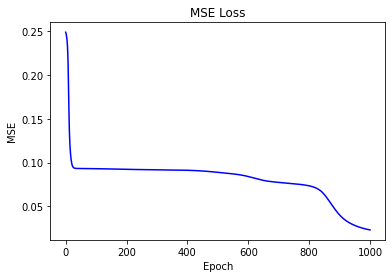

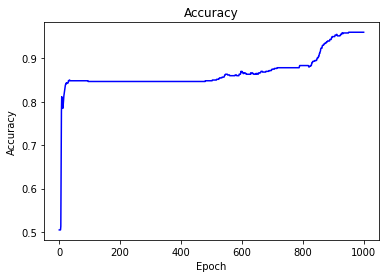

In [7]:
x = [i for i in range(0, 1001)]

plt.title("MSE Loss")
plt.plot(x, mses, color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.title("Accuracy")
plt.plot(x, accuracys, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()